## Visualizing Melbourne Pedestrian Counts

First we need some libraries

In [8]:
suppressPackageStartupMessages(library(rvest))       # devtools::install_github("hadley/rvest")
suppressPackageStartupMessages(library(httr))
suppressPackageStartupMessages(library(dplyr))
suppressPackageStartupMessages(library(xml2))        # devtools::install_github("hadley/xml2")
suppressPackageStartupMessages(library(pbapply))
suppressPackageStartupMessages(library(data.table))
suppressPackageStartupMessages(library(lubridate))
suppressPackageStartupMessages(library(tidyr))
suppressPackageStartupMessages(library(ggplot2))
suppressPackageStartupMessages(library(scales))
suppressPackageStartupMessages(library(grid))
suppressPackageStartupMessages(library(viridis))

options("warn"=-1) # disable warning messages for cleaner output

Next we get the list of data files from the site by scraping the download page for the URLs and storing them locally. The use of `write_disk` makes for a free "caching" function as well.

In [9]:
data_dir <- ifelse(basename(getwd())=="R", "../data", "./data")

data_dir <- "./data"
base_url <- "http://www.pedestrian.melbourne.vic.gov.au/"

pg <- read_html(modify_url(base_url, path="datadownload.html"))

pg %>%
  html_nodes("a[href^='datadownload']") %>%
  html_attr("href") %>%
  pbsapply(function(x) {
    dfile <- basename(x)
    invisible(try(GET(modify_url(base_url, path=x),
                      write_disk(file.path(data_dir, dfile))),
                  silent=TRUE))
    dfile
  }) -> data_files

We're not using `data.table` operations for speed (it's not very large data). `fread` just worked better than `readr::read_csv`. It does have the added benefit of being fast.

In [10]:
rbindlist(pblapply(data_files, function(x) {
  data.table::fread(file.path(data_dir, x), verbose=FALSE)
}), fill=TRUE) -> walking

walking$Date <- parse_date_time(walking$Date, orders=c("mdY", "dby", "dmY"))

Now we get the counts by day of week and hour of day. 
There are many ways to visualize this data. This is just one of them.

In [11]:
walking <- gather(walking, location, count, -Date, -Hour)
walking$count <- as.numeric(walking$count)
walking <- filter(walking, !is.na(count))
walking$weekday <- wday(walking$Date, label=TRUE)

walking %>% count(weekday, Hour, wt=count) -> wday_totals

tbl_df(wday_totals) %>%
  mutate(Hour=factor(Hour),
         weekday=factor(weekday)) %>%
  rename(`Total Walkers\n(log scale)`=n) -> wday_totals

And, finally, we plot it heatmap style.

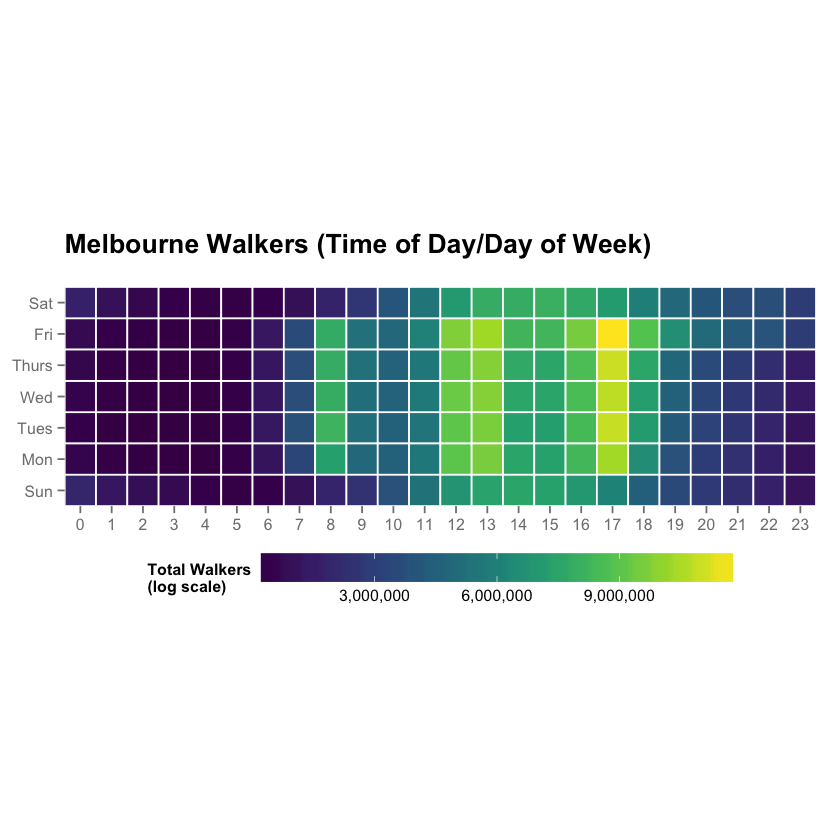

In [12]:
palette <- viridis(9)

ggplot(wday_totals, aes(x=Hour, y=weekday)) +
  geom_tile(aes(fill=`Total Walkers\n(log scale)`), color="white", size=0.5) +
  scale_x_discrete(expand=c(0, 0)) +
  scale_y_discrete(expand=c(0, 0)) +
  scale_fill_gradientn(label=comma, colours=palette) +
  coord_equal() +
  labs(x=NULL, y=NULL, title="Melbourne Walkers (Time of Day/Day of Week)\n") +
  theme(plot.title=element_text(face="bold", hjust=0, size=16)) +
  theme(legend.key.width=unit(2, "cm")) +
  theme(legend.position="bottom")

And, we can even make these interactive

In [13]:
library(d3heatmap)
library(htmltools)

wday_totals %>%
  select(weekday=1, hour=2, total=3) %>% 
  spread(hour, total) %>% 
  data.frame -> wday_df

rownames(wday_df) <- wday_df$weekday

select(wday_df, -weekday) %>%
  as.matrix() %>%
  d3heatmap(width=600, height=300,dendrogram="none", colors=palette) %>%
  html_print()